<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***15% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-12 to 2025-06-09
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-09.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 1000 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 1000 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 1000 articles fetched
Fetching page 12/15...
Page 12: 999 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 998 articles fetched
Fetching page 15/15...
Page 15: 1000 articles fetched
Total articles fetched: 14997


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""NAV""","""2025-06-10 14:53:15""","""REITweek Conference: Fresh Dat…",null,"""seekingalpha.com""","""REITweek 2025 highlighted a ma…","""https://seekingalpha.com/artic…"
"""ALB""","""2025-06-10 14:52:17""","""Albemarle Stock: Lithium Glut …","""https://images.financialmodeli…","""seekingalpha.com""","""Lithium glut persists, pressur…","""https://seekingalpha.com/artic…"
"""META""","""2025-06-10 14:51:00""","""How Meta Platforms Became 2025…",null,"""barrons.com""","""The stock is gapping its Magni…","""https://www.barrons.com/articl…"
"""TSCO""","""2025-06-10 14:50:13""","""Tailwinds in Pet Business: A C…","""https://images.financialmodeli…","""zacks.com""","""Tractor Supply enhances presen…","""https://www.zacks.com/stock/ne…"
"""ADBE""","""2025-06-10 14:50:11""","""Will Adobe (ADBE) Stock Reboun…","""https://images.financialmodeli…","""zacks.com""","""Set to report its Q2 results o…","""https://www.zacks.com/stock/ne…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

Loading fundamental data...
Loaded 504 stocks, 4182 unique tickers
Analyzing sentiment for stock symbols...

Screened 1642 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""ENGIY""",3,0.7728,0.0,1.0,0.5455,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CARG""",4,0.7626,0.0,1.0,0.5251,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""PAG""",3,0.7523,0.0,1.0,0.5046,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""DTE""",8,0.7473,0.0,1.0,0.4947,8,0.4896,0.5645,"""Utilities""",2.8357e10,18.44,136.65
"""UPBD""",4,0.7446,0.0,0.75,0.4892,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Real Estate""",26,0.596123,0.621604,7.307692,3.8078e10,NaN
"""Industrials""",54,0.571676,0.566306,10.148148,6.5031e10,NaN
"""Consumer Cyclical""",45,0.57126,0.571809,15.2,1.2722e11,32.354444
"""Consumer Defensive""",31,0.569203,0.526494,17.612903,1.0579e11,NaN
"""Technology""",75,0.568828,0.514012,17.32,2.2165e11,NaN
…,…,…,…,…,…,…
"""Utilities""",28,0.564496,0.489568,16.857143,3.9459e10,21.358571
"""Healthcare""",56,0.563948,0.492446,13.285714,8.4867e10,NaN
"""Financial Services""",54,0.558009,0.504254,14.055556,1.0580e11,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 6 tickers already in long-term portfolio: ['MMC', 'AMAT', 'MRK', 'TMUS', 'APO', 'PG']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""DTE""",8,0.7473,0.0,1.0,0.4947,8,0.4896,0.5645,"""Utilities""",2.8357e10,18.44,136.65
"""PODD""",3,0.724,0.0,1.0,0.448,3,0.4924,0.5639,"""Healthcare""",2.2874e10,58.46,325.03
"""USB""",3,0.7181,0.0,1.0,0.4361,3,0.5043,0.558,"""Financial Services""",6.7915e10,10.79,43.59
"""EL""",4,0.6914,0.0,1.0,0.3827,4,0.5265,0.5692,"""Consumer Defensive""",2.4082e10,NaN,66.94
"""SNPS""",3,0.6864,0.0,1.0,0.3727,3,0.514,0.5688,"""Technology""",7.1992e10,53.76,463.98



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",19,0.229605,0.614805,0.714721
"""Industrials""",16,0.233363,0.616675,0.768975
"""Consumer Cyclical""",10,0.24066,0.62032,0.79022
"""Financial Services""",10,0.23018,0.61509,0.82828
"""Healthcare""",10,0.25308,0.62655,0.74587



Summary statistics for selected stocks:
Average sentiment score: 0.2375
Min sentiment score: 0.1681
Max sentiment score: 0.4947
Average company news score: 0.6188
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import load_and_filter_data

quotes = load_and_filter_data('data/daily_stock_quotes.csv', screened_tickers, start_date, end_date)
# quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
quotes = quotes.dropna(axis=1, how='any').dropna(axis=0, how='any')
available_tickers = quotes.columns.tolist()

print(f"Available tickers after cleaning: {available_tickers}")
print(f"Dataset shape after cleaning: {quotes.shape}")
print(f"Date range: {quotes.index[0]} to {quotes.index[-1]}")
display(quotes.head())

Found 99 of 100 tickers in data/daily_stock_quotes.csv
Missing tickers: ['GEV']
Available tickers after cleaning: ['ABT', 'ACN', 'AES', 'ALB', 'ALL', 'AMP', 'AON', 'APTV', 'ATO', 'AWK', 'BAC', 'BK', 'BKNG', 'CB', 'CHRW', 'CLX', 'CMCSA', 'CMS', 'CNC', 'COST', 'CPB', 'CSCO', 'CTAS', 'CVS', 'DAL', 'DPZ', 'DTE', 'DVN', 'EL', 'EMR', 'ENPH', 'EOG', 'ETN', 'FAST', 'FI', 'FOX', 'FRT', 'FSLR', 'GE', 'GEN', 'GOOGL', 'GPC', 'GRMN', 'HCA', 'HD', 'HWM', 'IFF', 'INTU', 'ISRG', 'KLAC', 'MCHP', 'MCK', 'MDT', 'MMM', 'MOH', 'MSFT', 'MTCH', 'MU', 'NEE', 'NEM', 'NOW', 'NRG', 'NTAP', 'O', 'OKE', 'OXY', 'PANW', 'PEG', 'PEP', 'PH', 'PLD', 'PODD', 'RCL', 'REG', 'RF', 'ROK', 'RTX', 'SBUX', 'SLB', 'SMCI', 'SNPS', 'STX', 'TGT', 'TJX', 'TSCO', 'UAL', 'ULTA', 'USB', 'VRSK', 'VZ', 'WDAY', 'WELL', 'WMT', 'WTW', 'ZTS']
Dataset shape after cleaning: (2509, 95)
Date range: 2015-06-15 00:00:00 to 2025-06-04 00:00:00


,ABT,ACN,AES,ALB,ALL,AMP,AON,APTV,ATO,AWK,...,UAL,ULTA,USB,VRSK,VZ,WDAY,WELL,WMT,WTW,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-15,39.75,81.32,9.33,50.59,53.73,102.97,93.31,66.97,40.69,40.99,...,52.250000,154.570000,31.33,71.00,28.14,79.570000,45.35,19.82,107.89,45.70
2015-06-16,40.09,82.09,9.43,50.64,54.26,103.43,94.04,67.25,41.09,40.68,...,51.230000,155.500000,31.47,71.22,28.39,78.989998,45.67,19.93,108.21,46.11
2015-06-17,40.16,82.29,9.49,51.05,54.14,103.34,94.36,68.15,41.23,40.86,...,51.320000,155.619995,31.50,71.86,28.30,79.099998,45.82,20.04,108.46,46.53
2015-06-18,41.30,82.61,9.62,52.09,55.09,104.25,95.09,68.31,41.84,41.59,...,52.009998,156.479996,31.60,72.37,28.60,80.470000,46.26,20.11,109.14,46.84
2015-06-19,41.25,82.37,9.62,51.19,53.55,102.93,93.70,68.39,41.69,41.47,...,53.250000,154.729996,31.50,72.30,28.41,79.970000,46.17,20.04,108.12,46.60


### Step 7: Split Data into Training and Testing Sets

In [10]:
# Split data into 80% training and 20% testing based on date
total_rows = len(quotes)
train_size = int(0.8 * total_rows)
training_set = quotes.iloc[:train_size]
test_set = quotes.iloc[train_size:]

print(f"Training: {len(training_set)} rows ({len(training_set)/total_rows:.1%}) | Testing: {len(test_set)} rows ({len(test_set)/total_rows:.1%})")
print(f"Training period: {training_set.index[0]} to {training_set.index[-1]}")
print(f"Testing period: {test_set.index[0]} to {test_set.index[-1]}")

Training: 2007 rows (80.0%) | Testing: 502 rows (20.0%)
Training period: 2015-06-15 00:00:00 to 2023-06-02 00:00:00
Testing period: 2023-06-05 00:00:00 to 2025-06-04 00:00:00


### Step 8: Find Best Strategy -- Training Set
- Backtest & Optimize Strategies (Loop through different parameters)
- Select Top Stocks ***(by Sortino Ratio)***

In [11]:
daily_risk_free_df.columns.str.title()

daily_risk_free_df

,^IRX
Date,
2015-06-15,0.003
2015-06-16,0.008
2015-06-17,0.003
2015-06-18,0.003
2015-06-19,0.003
...,...
2025-05-29,4.230
2025-05-30,4.230
2025-06-02,4.230


,Ticker,Strategy,Best_Sharpe,Best_Sortino,CAGR,Max_Drawdown,Volatility,Short_Period,Long_Period
0,MSFT,SMA_Cross_Signal,1.013240,1.342995,0.269688,-0.280423,0.272362,75,130
1,GRMN,SMA_Cross_Signal,0.715534,1.009217,0.166281,-0.494772,0.262905,60,100


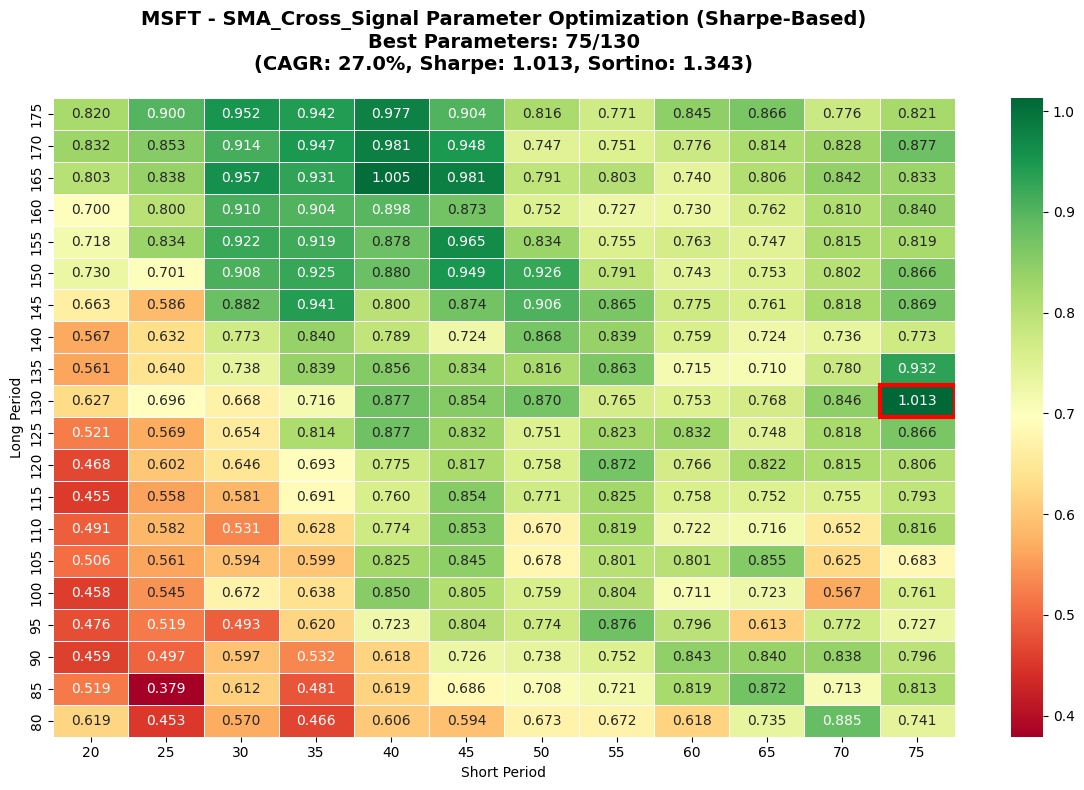

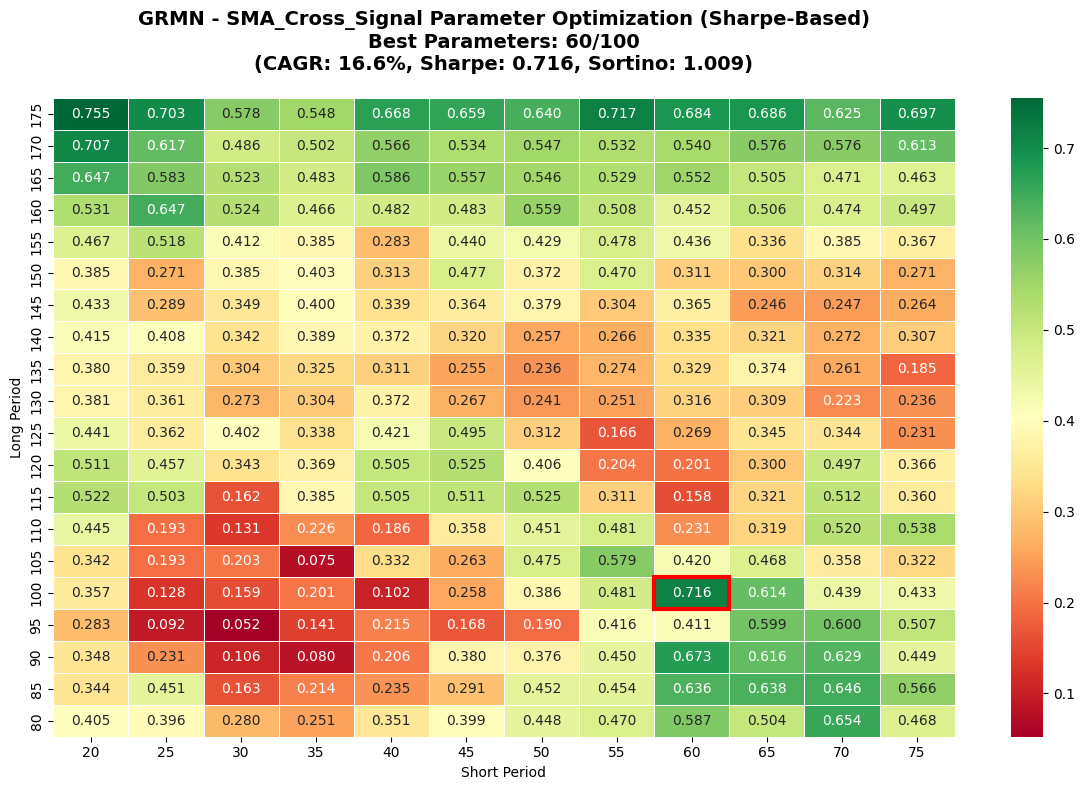

In [12]:
# In your notebook cell, update the optimization call:
from py.technical_analysis import find_optimal_portfolio_with_parameter_optimization, plot_optimization_heatmaps

performance_metric = 'sharpe' # Choose: 'cagr', 'sharpe', or 'sortino'
max_stocks = 2            # Top N stocks by performance metric

# Define Parameter ranges
# parameter_ranges = {
#     'SMA_Cross_Signal': {
#         'short_periods': [10, 15, 20, 25, 30, 35, 40],
#         'long_periods': [60, 80, 100, 120, 140, 160, 180, 200]
#     },
#     'EMA_Cross_Signal': {
#         'short_periods': [8, 12, 16, 20, 24, 28],
#         'long_periods': [35, 40, 45, 50, 55, 60, 65]
#     }
# }

parameter_ranges = {
    'SMA_Cross_Signal': {
        'short_periods': list(range(20, 80, 5)),
        'long_periods': list(range(80, 180, 5))     
    },
    'EMA_Cross_Signal': {
        'short_periods': list(range(8, 40, 2)),      
        'long_periods': list(range(40, 80, 5))       
    }
}

# Fast optimization with custom parameter ranges
optimization_results = find_optimal_portfolio_with_parameter_optimization(
    quotes=training_set,
    # min_cagr=0.1,             # Minimum 10% annual return
    # max_volatility=0.3,       # Maximum 30% volatility
    max_stocks=max_stocks,    # Top 2 stocks by Sortino ratio
    n_jobs=4,                 # Parallel processing cores
    heatmap_metric=performance_metric,
    parameter_ranges=parameter_ranges 
)

# Access results
optimization_summary = optimization_results['optimization_summary']
portfolio_stats = optimization_results['portfolio_stats']
selected_tickers = optimization_results['selected_tickers']

display(optimization_summary)

# Plot heatmaps with different metrics:
plot_optimization_heatmaps(optimization_results, metric=performance_metric)

### Step 9: Test the Strategy -- Testing Set

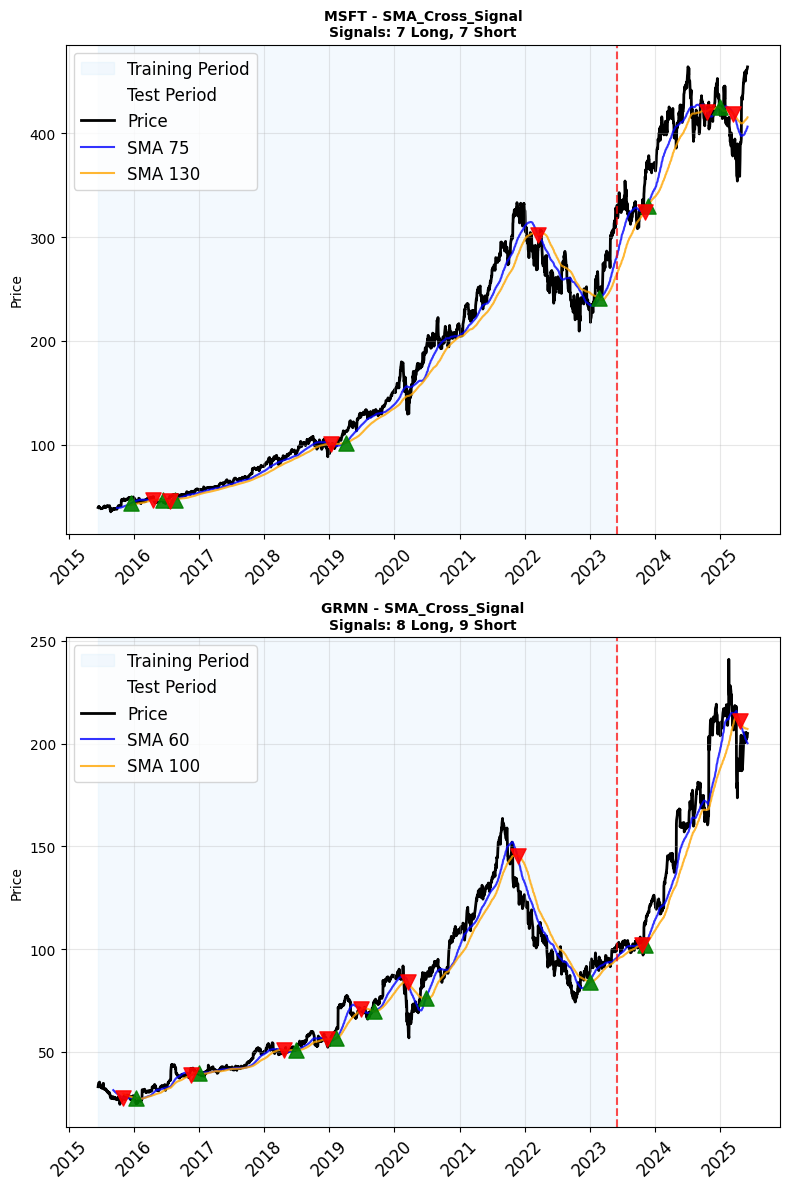

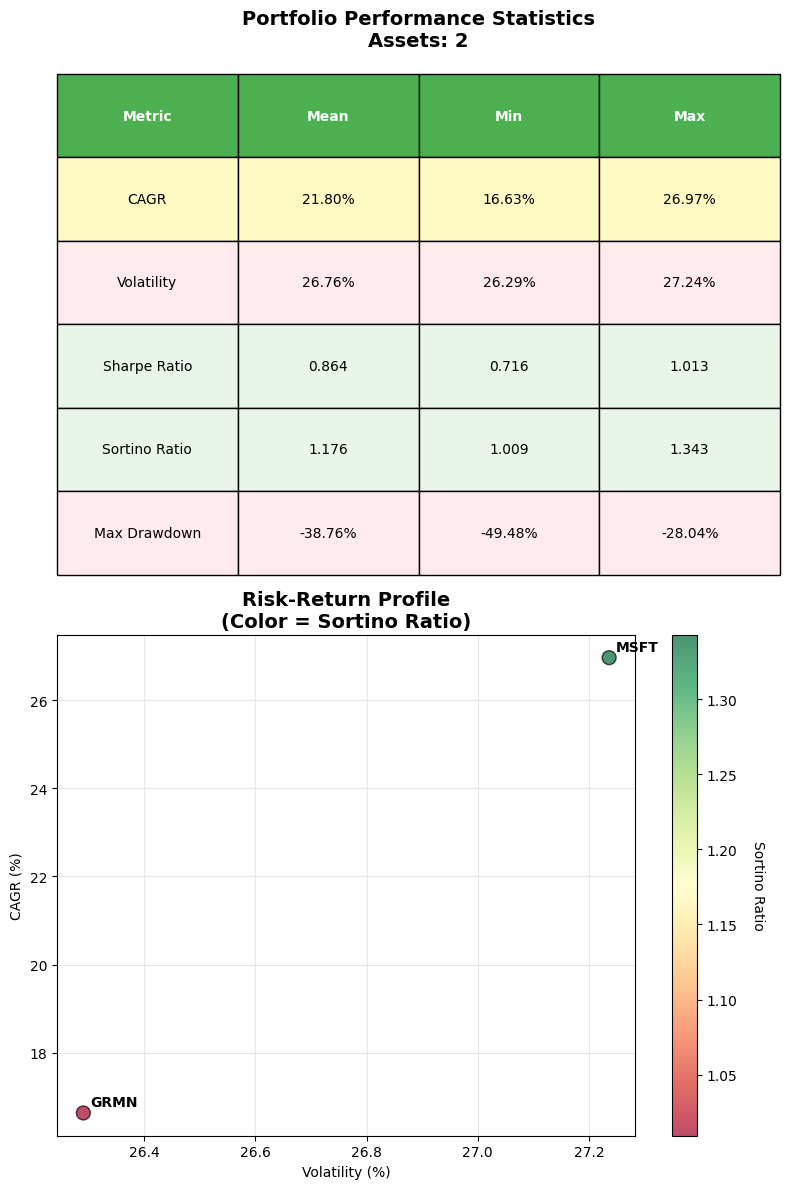

Selected tickers: ['MSFT', 'GRMN']
Portfolio weights type: <class 'pandas.core.frame.DataFrame'>
Test set date range: 2023-06-05 00:00:00 to 2025-06-04 00:00:00
Portfolio test data shape: (502, 2)
Portfolio test data date range: 2023-06-05 00:00:00 to 2025-06-04 00:00:00
Final weights: {'MSFT': 0.5, 'GRMN': 0.5}


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Stat                 Short-Term (SMA) Strategy
-------------------  ---------------------------
Start                2023-06-04
End                  2025-06-04
Risk-free rate       4.24%

Total Return         73.09%
Daily Sharpe         1.12
Daily Sortino        2.08
CAGR                 31.54%
Max Drawdown         -21.27%
Calmar Ratio         1.48

MTD                  0.87%
3m                   6.40%
6m                   1.74%
YTD                  5.80%
1Y                   22.13%
3Y (ann.)            31.54%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  31.54%

Daily Sharpe         1.12
Daily Sortino        2.08
Daily Mean (ann.)    30.21%
Daily Vol (ann.)     23.24%
Daily Skew           1.64
Daily Kurt           16.95
Best Day             11.62%
Worst Day            -8.64%

Monthly Sharpe       1.33
Monthly Sortino      4.07
Monthly Mean (ann.)  29.11%
Monthly Vol (ann.)   18.71%
Monthly Skew         0.90
Monthly Kurt         0.57
Best Month           15.81%
Wor

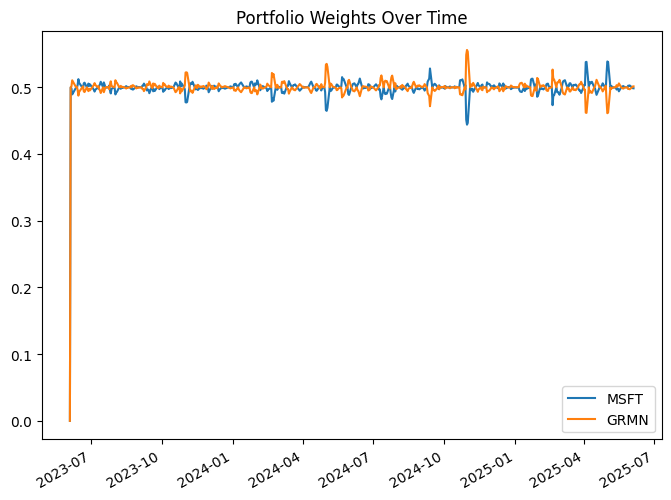

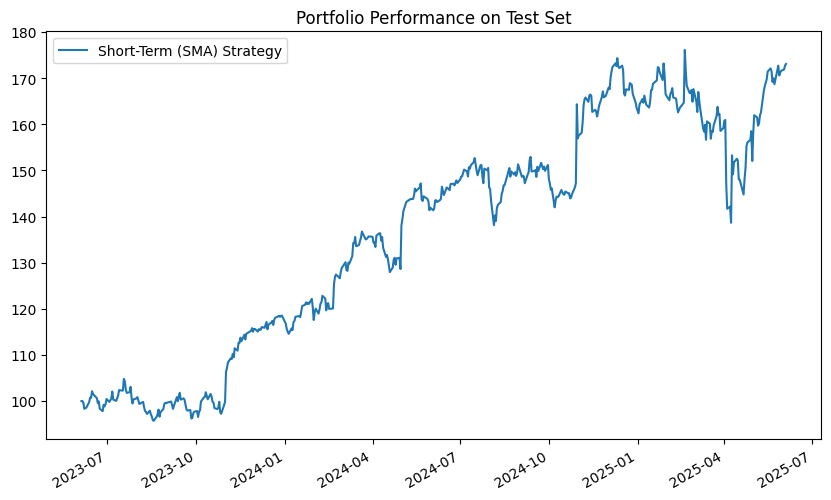

In [13]:
from py.technical_analysis import plot_portfolio_performance, plot_complete_strategy_analysis

# Generate and plot complete strategy analysis
plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=1) # 1 column layout (vertical stack)
# plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=2, rows=2) # Fixed 2x2 grid
plot_portfolio_performance(optimization_summary, cols=1, rows=2)  # 2 columns to show both table AND risk-return profile

# Use the portfolio result from optimization_results
if 'portfolio_result' in optimization_results:
    optimization_results['portfolio_result'].plot_security_weights()
    portfolio_result = optimization_results['portfolio_result']
else:
    # Alternative: Create a quick portfolio backtest to get weights
    portfolio_weights = optimization_results['portfolio_weights']
    selected_tickers = optimization_results['selected_tickers']
    
    # Debug: Check what we have
    print(f"Selected tickers: {selected_tickers}")
    print(f"Portfolio weights type: {type(portfolio_weights)}")
    print(f"Test set date range: {test_set.index[0]} to {test_set.index[-1]}")
    
    # Create a subset of quotes for selected tickers
    portfolio_quotes = quotes[selected_tickers].dropna()
    
    # Filter portfolio_quotes by test_set date range (use .loc for date filtering)
    portfolio_test_data = portfolio_quotes.loc[test_set.index]
    
    print(f"Portfolio test data shape: {portfolio_test_data.shape}")
    print(f"Portfolio test data date range: {portfolio_test_data.index[0]} to {portfolio_test_data.index[-1]}")
    
    # Handle portfolio_weights properly
    if isinstance(portfolio_weights, pd.DataFrame):
        # Extract weights - check if it's a DataFrame with weights
        if len(portfolio_weights) == len(selected_tickers):
            # Assuming each row corresponds to a ticker
            weights_dict = {ticker: portfolio_weights.iloc[i, 0] for i, ticker in enumerate(selected_tickers)}
        else:
            # Equal weights fallback
            weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}
    elif isinstance(portfolio_weights, dict):
        weights_dict = {ticker: portfolio_weights.get(ticker, 1.0/len(selected_tickers)) for ticker in selected_tickers}
    else:
        # Equal weights fallback
        weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}
    
    # Normalize weights to sum to 1
    total_weight = sum(weights_dict.values())
    if total_weight > 0:
        weights_dict = {k: v/total_weight for k, v in weights_dict.items()}
    
    print(f"Final weights: {weights_dict}")
    
    # Create and run portfolio backtest
    portfolio_strategy = bt.Strategy('Short-Term (SMA) Strategy', 
                     [
                         bt.algos.RunWeekly(),                 
                         bt.algos.SelectAll(),
                         bt.algos.WeighSpecified(**weights_dict),  # Unpack the dictionary       
                         bt.algos.Rebalance()
                     ]
                 )     
    
    # Run backtest on the filtered test data
    portfolio_backtest = bt.Backtest(portfolio_strategy, portfolio_test_data)
    portfolio_result = bt.run(portfolio_backtest)
    
    # Set risk-free rate if available
    if 'risk_free_rate' in globals():
        portfolio_result.set_riskfree_rate(risk_free_rate)

# Display results
if 'portfolio_result' in locals():
    # With custom parameters
    portfolio_result.plot_security_weights(
        figsize=(8, 6),
        title='Portfolio Weights Over Time'
    )
    
    portfolio_result.display()
    
    # Additional performance plot
    portfolio_result.plot(figsize=(10, 6), title='Portfolio Performance on Test Set')
else:
    print("Portfolio result not available")

### Step 10: Merge Strategy with Fundamental + Sentiment Analysis Data

In [14]:
from py.utils import clean_column_names

# Use optimization_results instead of analysis_results
print("Selected tickers from optimization_results:")
print(selected_tickers)

# Create a DataFrame with tickers and merge with optimization_summary
optimization_summary_with_tickers = optimization_summary.copy()
optimization_summary_with_tickers['Ticker'] = [ticker.upper() for ticker in selected_tickers]

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(optimization_summary_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas if needed for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)

# Add weights based on Sortino Ratio (assuming this column exists in the data)
if 'sortino_ratio' in short_term_portfolio_df.columns:
    # Normalize Sortino ratios to create weights
    sortino_sum = short_term_portfolio_df['sortino_ratio'].sum()
    short_term_portfolio_df['Weight'] = short_term_portfolio_df['sortino_ratio'] / sortino_sum
else:
    # Fallback to equal weights if Sortino ratio not available
    short_term_portfolio_df['Weight'] = 1.0 / len(short_term_portfolio_df)

# Verify weights sum to 1
print(f"Total portfolio weight: {short_term_portfolio_df['Weight'].sum():.6f}")

display(short_term_portfolio_df)

Selected tickers from optimization_results:
['MSFT', 'GRMN']
Total portfolio weight: 1.000000


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score,Weight
Ticker,,,,,,,,,,,,,,,,,,,,,
GRMN,2025-06-02,Garmin Ltd.,Technology,Scientific & Technical Instruments,Switzerland,https://www.garmin.com,3.908005e+10,3.658406e+10,1.747949e+08,1.925410e+08,...,60,100,6,0.6524,0.0000,0.6667,0.3048,0.514,0.5688,0.5
MSFT,2025-06-02,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3.421644e+12,3.447047e+12,7.422064e+09,7.432540e+09,...,75,130,46,0.6189,0.0435,0.7174,0.2379,0.514,0.5688,0.5


### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [15]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,GRMN,MSFT,^IRX
Date,,,
2025-06-01,204.95,463.87,4.240
2025-05-01,202.97,460.36,4.230
2025-04-01,186.87,394.54,4.190
2025-03-01,217.13,374.70,4.190
2025-02-01,228.11,396.26,4.193
...,...,...,...
2015-10-01,26.86,45.94,0.068
2015-09-01,27.17,38.63,0.005
2015-08-01,28.08,37.98,0.003


#### Export DataFrame to Excel

In [16]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

Updated sheet 'short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-09.xlsx
